# PA - Estudo de Sistema de Recomendação com dados da Amazon.

# Sprint 1

In [1]:
# BASE DE DADOS: http://jmcauley.ucsd.edu/data/amazon/links.html

In [2]:
#bibliotecas basicas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# mportação SURPRISE
from surprise import KNNWithMeans
from surprise import KNNBaseline
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
import os
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.slope_one import SlopeOne
from surprise.prediction_algorithms.co_clustering import CoClustering

### Importação base 

In [3]:
df_beleza = pd.read_csv('dados/ratings_Beauty.csv', names = ['userID', 'prodID', 'ratings', 'data'], header = 0)

In [4]:
df_beleza.shape

(2023069, 4)

In [5]:
df_beleza.head(10)

,userID,prodID,ratings,data
0,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
1,A1Z513UWSAAO0F,0558925278,5.0,1404691200
2,A1WMRR494NWEWV,0733001998,4.0,1382572800
3,A3IAAVS479H7M7,0737104473,1.0,1274227200
4,AKJHHD5VEH7VG,0762451459,5.0,1404518400
5,A1BG8QW55XHN6U,1304139212,5.0,1371945600
6,A22VW0P4VZHDE3,1304139220,5.0,1373068800
7,A3V3RE4132GKRO,130414089X,5.0,1401840000
8,A327B0I7CYTEJC,130414643X,4.0,1389052800
9,A1BG8QW55XHN6U,130414643X,5.0,1372032000


### Análise Exploratória

In [6]:
type(df_beleza)

pandas.core.frame.DataFrame

In [7]:
#tipos das variaveis e tamanho
df_beleza.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2023069 entries, 0 to 2023068
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userID   object 
 1   prodID   object 
 2   ratings  float64
 3   data     int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 61.7+ MB


In [8]:
# valores nulos na base
df_beleza.isnull().sum()

userID     0
prodID     0
ratings    0
data       0
dtype: int64

In [9]:
df_beleza.describe()['ratings']

count    2.023069e+06
mean     4.149035e+00
std      1.311505e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: ratings, dtype: float64

C:\Users\thais\anaconda3\lib\site-packages\seaborn\categorical.py:3704: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
C:\Users\thais\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


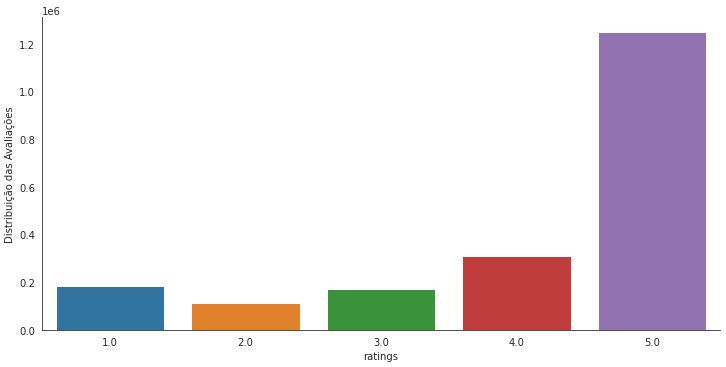

In [10]:
# distribuição das avaliações
with sns.axes_style('white'):
    g = sns.factorplot("ratings", data=df_beleza, aspect=2.0,kind='count')
    g.set_ylabels("Distribuição das Avaliações")

In [11]:
# agrupando as avaliações dos usuarios
usuarios = df_beleza.groupby(by='userID')['ratings'].count().sort_values(ascending=False)
usuarios.head(10)

userID
A3KEZLJ59C1JVH    389
A281NPSIMI1C2R    336
A3M174IC0VXOS2    326
A2V5R832QCSOMX    278
A3LJLRIZL38GG3    276
ALQGOMOY1F5X9     275
AKMEY1BSHSDG7     269
A3R9H6OKZHHRJD    259
A1M04H40ZVGWVG    249
A1RRMZKOMZ2M7J    225
Name: ratings, dtype: int64

In [12]:
usuarios.describe()

count    1.210271e+06
mean     1.671583e+00
std      2.531884e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      3.890000e+02
Name: ratings, dtype: float64

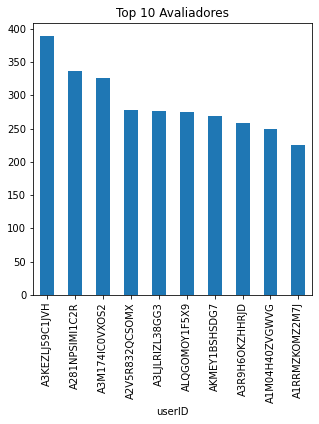

In [13]:
#usuarios que mais avaliaram
plt.figure(figsize=(5,5))
usuarios.head(10).plot(kind='bar')
plt.title("Top 10 Avaliadores")
plt.show()

In [14]:
# agrupando por produtos
top_beleza = df_beleza.groupby(by='prodID')['ratings'].count().sort_values(ascending=False)
top_beleza.head(10)

prodID
B001MA0QY2    7533
B0009V1YR8    2869
B0043OYFKU    2477
B0000YUXI0    2143
B003V265QW    2088
B000ZMBSPE    2041
B003BQ6QXK    1918
B004OHQR1Q    1885
B00121UVU0    1838
B000FS05VG    1589
Name: ratings, dtype: int64

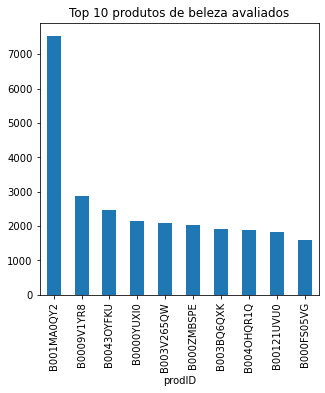

In [15]:
#Beleza mais avaliados
plt.figure(figsize=(5,5))
top_beleza.head(10).plot(kind='bar')
plt.title("Top 10 produtos de beleza avaliados")
plt.show()

# SPRINT 2

In [16]:
#Usuarios que avaliaram mais de 50 vezes 
base_usuarios_mais = df_beleza.groupby('userID').ratings.count().sort_values(ascending=False)

print('Quantidade de Usuários que avaliaram mais de 50 vezes: {}'.format(sum(base_usuarios_mais>=50)))

Quantidade de Usuários que avaliaram mais de 50 vezes: 361


In [17]:
#produtos de beleza avaliados mais de 50 vezes 
base_beleza_mais = df_beleza.groupby('prodID').ratings.count().sort_values(ascending=False)

print('Produtos de beleza avaliados mais de 50 vezes: {}'.format(sum(base_beleza_mais>=50)))

Produtos de beleza avaliados mais de 50 vezes: 6971


### Definindo nova base com produtos de beleza que tiveram pelo menos 50 avaliações

In [18]:
base_up = df_beleza.groupby("prodID").filter(lambda x:x['ratings'].count() >=50)

In [19]:
base_up.head(5)

,userID,prodID,ratings,data
1704,A2SR9M2CWC2OCP,9790790961,4.0,1379894400
1705,A3V1EVBYP0U77W,9790790961,2.0,1397606400
1706,AVJKKAS4P52P9,9790790961,5.0,1404432000
1707,A2NQQDBBGFW1OT,9790790961,5.0,1390694400
1708,A1OFNEUHZ7BSCB,9790790961,5.0,1392336000


In [20]:
#tamanho da nova base
base_up.shape

(906759, 4)

### Calculando média e contagem para a base df

In [21]:
df = df['media_avaliacoes'] = pd.DataFrame(base_up.groupby('prodID').ratings.mean())

In [22]:
df['total_avaliacoes'] = base_up.groupby('prodID').ratings.count()

In [23]:
df.head(5)

,ratings,media_avaliacoes,total_avaliacoes
prodID,,,
9790790961,4.271429,4.271429,70
9790799829,2.640000,2.640000,50
B00004TMFE,3.445255,3.445255,137
B00004TUBL,4.634409,4.634409,558
B00004TUBV,4.269006,4.269006,171


## Recomendação: Baseada em Popularidade 

In [24]:
#ordenando por contagem
df.sort_values(by='total_avaliacoes', ascending=False).head(10)

,ratings,media_avaliacoes,total_avaliacoes
prodID,,,
B001MA0QY2,4.321386,4.321386,7533
B0009V1YR8,3.568839,3.568839,2869
B0043OYFKU,4.310456,4.310456,2477
B0000YUXI0,4.405040,4.405040,2143
B003V265QW,4.365421,4.365421,2088
B000ZMBSPE,4.422342,4.422342,2041
B003BQ6QXK,4.625652,4.625652,1918
B004OHQR1Q,4.465782,4.465782,1885
B00121UVU0,4.538085,4.538085,1838


In [25]:
#ordenando por média
df.sort_values(by='ratings', ascending=False).head(10)

,ratings,media_avaliacoes,total_avaliacoes
prodID,,,
B004CNRDBU,5.000000,5.000000,58
B00K7ER6LU,4.976471,4.976471,85
B00KH6F6TM,4.965517,4.965517,58
B00FPROWWU,4.962025,4.962025,79
B002YFN49I,4.948980,4.948980,98
B00J3K9W6G,4.943396,4.943396,53
B009OWSHQE,4.943182,4.943182,88
B001PX1AIC,4.920635,4.920635,63
B00I46E8DC,4.912791,4.912791,172


## Recomendação: Filtragem Colaborativa baseada em item

### Configurando os parametros

In [27]:
# escala de avaliação que varia entre 0 e 5.
reader = Reader(rating_scale=(0,5))

In [28]:
#selecionando as colunas
data = Dataset.load_from_df(base_up[['userID', 'prodID', 'ratings']], reader)

In [29]:
# divisão dos dados de treino e teste 70/30
trainset, testset = train_test_split(data, test_size=.3, random_state=1)

## Modelo KNNWithMeans

In [30]:
#medidas de similariedade
#user_based False = similaridade dos itens
sim_options_means = { 'name': 'msd', 'user_based': False }

In [31]:
# Criação do modelo
#máximo de vizinhos a serem considerados. O padrão é 40.
modelo_knn_means = KNNWithMeans(k=40, sim_options=sim_options_means)

In [32]:
# Treinamento do modelo
modelo_knn_means.fit(trainset)

Computing the msd similarity matrix...
Done computing similarity matrix.


In [33]:
#avaliando o modelo pela Raiz do Erro Quadrático Médio (RMSE)
predictions_knn_means = modelo_knn_means.test(testset)
accuracy.rmse(predictions_knn_means)

RMSE: 1.3022


1.3021733475218147

## Modelo KNNBaseline

In [51]:
sim_options = { 'name': 'pearson_baseline', 'user_based': False }

In [52]:
modelo_knn_base = KNNBaseline(k=40, sim_options=sim_options)

In [53]:
#treinando
modelo_knn_base.fit(trainset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [37]:
#avaliando o modelo pela Raiz do Erro Quadrático Médio (RMSE)
predictions_knn_base = modelo_knn_base.test(testset)
accuracy.rmse(predictions_knn_base)

RMSE: 1.2385


1.2385017251213521

# SPRINT 3

## SlopeOne

In [56]:
# Criação do modelo
slo = SlopeOne()

In [57]:
# Treinamento do modelo
slo.fit(trainset)

In [58]:
#avaliando o modelo pela Raiz do Erro Quadrático Médio (RMSE)
predictions_slo = slo.test(testset)
accuracy.rmse(predictions_slo)

RMSE: 1.3782


1.3781878509879075

## CoClustering

In [59]:
# Criação do modelo
#n_cltr_i ( int ) - Número de agrupamentos de itens
#n_epochs ( int ) - Número de iterações do loop de otimização, padrão é 20
co = CoClustering(n_cltr_i = 10, verbose=True, random_state=1)

In [60]:
# Treinamento do modelo
co.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19


In [61]:
#avaliando o modelo pela Raiz do Erro Quadrático Médio (RMSE)
predictions_co = co.test(testset)
accuracy.rmse(predictions_co)

RMSE: 1.3442


1.3441559302182182

### Entre os quatro modelos testados, apesar da pouca diferença, o melhor foi o KNNBaseline

## Gerando recomendação

In [38]:

#10 vizinhos + proximos
modelo_knn_base.get_neighbors(1, 10)

[4852, 424, 106, 0, 2, 3, 4, 5, 6, 7]

In [39]:
#para o usuario A3JM6GV9MNOF9X é recomendado esses produtos:
modelo_knn_base.get_neighbors(1, 10)

[4852, 424, 106, 0, 2, 3, 4, 5, 6, 7]

In [40]:
#buscando quais os produtos
df.iloc[[4852, 424, 106, 0, 2, 3, 4, 5, 6, 7]].index

Index(['B004VJ56AK', 'B0002Z1JJ4', 'B0000632EN', '9790790961', 'B00004TMFE',
       'B00004TUBL', 'B00004TUBV', 'B00004U9UY', 'B00004U9V2', 'B000050B6U'],
      dtype='object', name='prodID')